# Baseline without RAG.

Import packages.

In [1]:
import ast
import os
import pandas as pd

from datetime import datetime
from dotenv import load_dotenv
from json import loads, dumps
from langchain.tools import tool


from pydantic import BaseModel, Field
from typing import Annotated, Sequence, TypedDict, Literal

from IPython.display import Image, display


from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate

from langchain_openai import OpenAIEmbeddings, ChatOpenAI

from langfuse import Langfuse, get_client
from langfuse.langchain import CallbackHandler
from langfuse.openai import openai  # Don't delete this line.

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, END, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import tools_condition, ToolNode

Set up environment variables.

In [2]:
# Set up environment variables.
load_dotenv(override=True)
openai_api_key = os.getenv('OPENAI_API_KEY')

# Monitor if the environment variables are ready.
if openai_api_key:
    print(f"OpenAI API Key exists and begins {openai_api_key[:8]}")
else:
    print("OpenAI API Key not set - please head to the troubleshooting guide in the setup folder")

OpenAI API Key exists and begins sk-proj-


In [3]:
langfuse_secret_key = os.getenv('LANGFUSE_SECRET_KEY')
langfuse_public_key = os.getenv('LANGFUSE_PUBLIC_KEY')
langfuse = Langfuse(
    secret_key = langfuse_secret_key,
    public_key = langfuse_public_key,
    host="https://cloud.langfuse.com"
    # host = "https://us.cloud.langfuse.com"
)

langfuse = get_client()
 
# Verify connection
if langfuse.auth_check():
    print("Langfuse client is authenticated and ready!")
else:
    print("Authentication failed. Please check your credentials and host.")

Langfuse client is authenticated and ready!


In [4]:
completion = openai.chat.completions.create(
  name="test-chat",
  model="gpt-4o",
  messages=[
      {"role": "system", "content": "You are a very accurate calculator. You output only the result of the calculation."},
      {"role": "user", "content": "1 + 1 = "}],
  metadata={"someMetadataKey": "someValue"},
)

Define supporting variables and functions.

In [5]:
def format_job_descriptions(jd_dataframe):
    if isinstance(jd_dataframe, pd.Series):
        jd_dataframe = jd_dataframe.to_frame().T
    result = jd_dataframe.to_json(orient='records')
    return result

Function test.

In [6]:
df = pd.read_csv("data/X_test.csv")
test = df.iloc[0, :]
if isinstance(test, pd.Series):
        test = test.to_frame().T
json_records = test.to_json(orient='records')
parsed = loads(json_records)
print(dumps(parsed, indent=4) )

[
    {
        "title": "Driver / Tour Guide for Coach & 4WD Coach Tours",
        "abstract": "This role includes conducting 1-20 Day Tours to a range of locations all over Australia with mature passengers for a well established family company.",
        "job_description_clean": "Casey Australia Tours require a experienced Coach Drivers / Tour Guide for the rest of the 2019 season of extended motel and/or camping tours starting mid/late June The role requires driving, minor coach maintenance, cleaning, guiding and commentating plus some cooking. The ideal person should have; 1. A sense of humour and engaging personality 2. Initiative and problem solving skills 3. Confidence and be a good public speaker 4. A current manual HR drivers licence with F endorsement. (or ability to get one quickly) 5. A safe driving record 6. Clear Criminal History 7. Experience in some field that can be related 8. First Aid Training 9. Good Navigation in remote and city areas Handy assets to have; 1. Mecha

Define Graph Sate.

In [7]:
class AgentState(TypedDict):
    """
    Represents the state of graph.

    Attributes:
        messages: A list of messages in the conversation, including user input and agent outputs.

    Notes:
        The add_messages function defines how an update should be processed.
        Default is to replace. add_messages says "append".
    """
    messages: Annotated[Sequence[BaseMessage], add_messages]

Deinfe Basic Nodes.

Input: job description strings.

Host node

Conditional Edge: whether the question is about to check job descriptions.

If not, return generate.

If yes, go to next node.

Get industry information and professional skills.

Get general requirements.

Evaluate the job advertisement.

Refine the job advertisement.



In [8]:
def host_agent(state):
    """
    Invokes the whole workflow and monitor the state.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with the agent response appended to messages
    """
    
    print("---CALL HOST AGENT---")
    messages = state["messages"][-1].content
    
    model = ChatOpenAI(temperature=0, streaming=True, model="gpt-4-turbo")
    response = model.invoke(messages)
    
    return {"messages": [response]}

In [9]:
def industry_agent(state, config):
    """
    Generate answer. The core of RAG.

    Args:
        state (messages): The current state

    Returns:
         dict: The updated state with re-phrased question
    """
    print("---CALL INDUSTRY AGENT---")

    # Prompt
    prompt = PromptTemplate(
        template="""
            You are a helpful assistant that extracts structured information from a batch of job advertisements.

            Input job ad:
            {job_text}

            Instruction:
            Extract the following fields from the given batch of different job ads. If a field is not present, return an empty list for that field.

            - skills: short list of skills, tools, technologies (e.g., "Python", "SQL", "scikit-learn", "communication")
            - responsibilities: short concise list of responsibilities / duties described in the ad
            - requirements: candidate requirements such as experience, qualifications, degrees, certifications, years of experience

            Return a list of JSON objects ONLY with keys: "job_title", "skills", "responsibilities", "requirements", "classification", "salary". 

            Example:
            {{"job_title": ["Data Scientist"], "skills": ["Python", "SQL"], "responsibilities": ["build predictive models"], "requirements": ["3+ years experience", "Bachelor's degree"], "classification":["Information & Communication Technology"], "salary":["150,000 AUD"]}}
        """,
        input_variables=["job_text"],
    )

    # LLM
    llm = ChatOpenAI(model_name="gpt-4-turbo", temperature=0, streaming=True)

    # Chain
    chain = prompt | llm | StrOutputParser()

    # Run
    response = chain.invoke({"job_text": config["configurable"]["job_ads"][-1]})
    return {"messages": [response]}

In [52]:
def check_task_agent(state, config) -> Literal["industry_agent", "END"]:
    """
    Determines whether the question is about to check job descriptions.

    Args:
        state (messages): The current state

    Returns:
        str: A decision for whether the question is about to check job descriptions.
    """

    print("---CHECK TASK RELEVANCE---")

    
    if config["configurable"]["job_ads"][-1] is not None and len(config["configurable"]["job_ads"][-1]) >= 1:
        print("---DECISION: This is a job advertisement analysis task. ---")
        return "industry_agent"

    else:
        print("---DECISION: This is not a job advertisement analysis task.---")
        print("PLEASE INPUT JOB DESCRIPTIONS.")
        return "END"

In [53]:
def industry_agent(state, config):
    """
    Generate answer. The core of RAG.

    Args:
        state (messages): The current state

    Returns:
         dict: The updated state with re-phrased question
    """
    print("---CALL INDUSTRY AGENT---")

    # Prompt
    prompt = PromptTemplate(
        template="""
            You are a helpful assistant that extracts structured information from a batch of job advertisements.

            Input job ad:
            {job_text}

            Instruction:
            Extract the following fields from the given batch of different job ads. If a field is not present, return an empty list for that field.

            - skills: short list of skills, tools, technologies (e.g., "Python", "SQL", "scikit-learn", "communication")
            - responsibilities: short concise list of responsibilities / duties described in the ad
            - requirements: candidate requirements such as experience, qualifications, degrees, certifications, years of experience

            Return a JSON object ONLY with keys: "job_title", "skills", "responsibilities", "requirements", "classification", "salary", "location", "workType". 

            No other strings outside JSON objects.

            Example:
            {{"job_title": ["Data Scientist"], "skills": ["Python", "SQL"], "responsibilities": ["build predictive models"], "requirements": ["3+ years experience", "Bachelor's degree"], "classification":["Information & Communication Technology"], "salary":["150,000 AUD"], "location":["Sydney"], "workType":["Fulltime"]}}
        """,
        input_variables=["job_text"],
    )

    # LLM
    llm = ChatOpenAI(model_name="gpt-4-turbo", temperature=0, streaming=True)

    # Chain
    chain = prompt | llm | StrOutputParser()

    # Run
    response = chain.invoke({"job_text": config["configurable"]["job_ads"][-1]})
    return {"messages": [response]}

In [54]:
def evaluate_agent(state, config):
    """
    Generate answer. The core of RAG.

    Args:
        state (messages): The current state

    Returns:
         dict: The updated state with re-phrased question
    """
    print("---CALL EVALUATE AGENT---")
    messages = state["messages"]
    job_message = messages[-1]
    job_message_docs = job_message.content

    # Prompt
    prompt = PromptTemplate(
        template="""
            You are a helpful assistant that can evaluate the job advertisement information and give improve suggestions.

            Input job advertisement information:
            {job_message_docs}

            Instruction:
            Based on the current information, list the lacked part of job advertisement and the improved suggestion.
            
            Return a JSON object ONLY with keys: "job_title", "skills", "responsibilities", "requirements", "classification", "salary", "location", "workType". 

            No other strings outside JSON objects.

            Example:

            {{"skills":["Can be more clear", "Python, SQL, GCP"], "salary":["Missed", "Competitive Salary"], "location":["Missed"], "workType":["Missed"]}}
        """,
        input_variables=["job_message_docs"],
    )

    # LLM
    llm = ChatOpenAI(model_name="gpt-4-turbo", temperature=0, streaming=True)

    # Chain
    chain = prompt | llm | StrOutputParser()

    # Run
    response = chain.invoke({"job_message_docs": job_message_docs})
    return {"messages": [response]}

Complie the graph.

In [55]:
# Define a new graph
workflow = StateGraph(AgentState)

# Define the nodes.
workflow.add_node("host_agent", host_agent)  
workflow.add_node("industry_agent", industry_agent)  
workflow.add_node("evaluate_agent", evaluate_agent)  

# Call agent node to decide to retrieve or not
workflow.add_edge(START, "host_agent")
workflow.add_conditional_edges(
    "host_agent", 
    check_task_agent, 
    {
        "END": END,             # map this label to the END
        "industry_agent": "industry_agent", # map this one to a node
    })
workflow.add_edge("industry_agent", "evaluate_agent")
workflow.add_edge("evaluate_agent", END)

# Compile
graph = workflow.compile(checkpointer=MemorySaver())


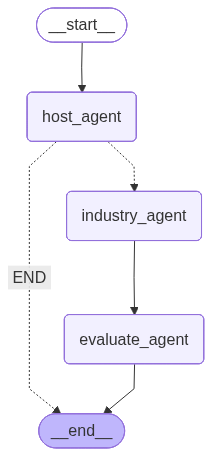

In [56]:
try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    pass

In [57]:
def agent_invoke(graph, question, job_ads, config):
    """
    Invoke the workflow with user question, generate human-friendly metrics and answers.

    Args:
        graph: The current workflow
        question: The user input to invoke the workflow
        config: The holder of thread, memory, and LangFuse

    Returns:
        retriever_counter: how many times the retriever tool is called for this question
        rewrite_counter: how many times the question is rewritten, which indicates a failed retrieval
        final_message: the answer that can be shown to all audience
    """
    # config["configurable"]["questions"].append(question)
    config["configurable"]["job_ads"].append(job_ads)

    analysis_message = []
    evaluate_message = []

    inputs = {
        "messages":[
            ("user", question)
        ]
    }

    for output in graph.stream(inputs, config=config):
        for key, value in output.items():
            # For Agent node, output tool call information.
            if key == 'host_agent':
                print("host_agent")
                # final_message = final_message + value['messages'][0].content
                print(value['messages'][0].content)
            # For retrieve tool node, counter plus.
            elif key == 'industry_agent':
                print("industry_agent")
                # final_messsage = final_message + value['messages'][0]
                print(value['messages'][0])
                analysis_message.append(value['messages'][0])

            elif key == 'evaluate_agent':
                print("evaluate_agent")
                # final_messsage = final_message + value['messages'][0]
                print(value['messages'][0])
                evaluate_message.append(value['messages'][0])
                print("\n---END QUESTION---")
            else:
                pass
    return analysis_message, evaluate_message

In [58]:
def deal_with_single_question(logs, graph, question, job_ads, config):
    """
    Deal with the workflow inputs and outputs, push them into local logging system.

    Args:
        logs: the list to store key information and metrics for the whole thread
        graph: The current workflow
        question: The user input to invoke the workflow
        config: The holder of thread, memory, and LangFuse
    """
    # Get the current date and time for time stamp.
    invoke_datetime = datetime.now().strftime("%Y%m%d_%H%M%S")
    analysis_message, evaluate_message = agent_invoke(graph, question, job_ads, config)
    thread_id = config['configurable']['thread_id']
    row =  [thread_id, invoke_datetime, analysis_message, evaluate_message]
    logs.append(row)

In [73]:
# Put LangFuse Handler when the workflow is invoked.

langfuse_handler = CallbackHandler()

In [74]:
config = {"configurable": {"thread_id": "langfuse-test", "questions": [], "job_ads":[], "callbacks": [langfuse_handler]}}
logs = []

In [75]:
config

{'configurable': {'thread_id': 'langfuse-test',
  'questions': [],
  'job_ads': [],
  'callbacks': [<langfuse.langchain.CallbackHandler.LangchainCallbackHandler at 0x2d7629f3790>]}}

In [76]:
df = pd.read_csv("data/X_test.csv")
test = df.iloc[0, :]
if isinstance(test, pd.Series):
        test = test.to_frame().T
json_records = test.to_json(orient='records')
parsed = loads(json_records)
print(dumps(parsed, indent=4) )

[
    {
        "title": "Driver / Tour Guide for Coach & 4WD Coach Tours",
        "abstract": "This role includes conducting 1-20 Day Tours to a range of locations all over Australia with mature passengers for a well established family company.",
        "job_description_clean": "Casey Australia Tours require a experienced Coach Drivers / Tour Guide for the rest of the 2019 season of extended motel and/or camping tours starting mid/late June The role requires driving, minor coach maintenance, cleaning, guiding and commentating plus some cooking. The ideal person should have; 1. A sense of humour and engaging personality 2. Initiative and problem solving skills 3. Confidence and be a good public speaker 4. A current manual HR drivers licence with F endorsement. (or ability to get one quickly) 5. A safe driving record 6. Clear Criminal History 7. Experience in some field that can be related 8. First Aid Training 9. Good Navigation in remote and city areas Handy assets to have; 1. Mecha

In [77]:
deal_with_single_question(logs, graph, "Hi, I'm Alexandra. Please help me analyse following job advertisements", json_records, config)

---CALL HOST AGENT---
---CHECK TASK RELEVANCE---
---DECISION: This is a job advertisement analysis task. ---
host_agent
Hello Alexandra! I'd be happy to help you analyze the job advertisements you have. Please provide the details of the job advertisements you'd like to discuss, and let me know what specific aspects you want to focus on (e.g., job requirements, qualifications, company culture, etc.).
---CALL INDUSTRY AGENT---
industry_agent
{
    "job_title": ["Driver / Tour Guide for Coach & 4WD Coach Tours"],
    "skills": ["driving", "minor coach maintenance", "cleaning", "guiding", "commentating", "cooking", "public speaking", "navigation", "mechanical knowledge", "camping", "group cooking"],
    "responsibilities": ["conducting 1-20 Day Tours", "driving", "coach maintenance", "cleaning", "guiding and commentating", "cooking"],
    "requirements": ["sense of humour and engaging personality", "initiative and problem solving skills", "confidence in public speaking", "current manual HR

In [78]:
test = df.iloc[3, :]
if isinstance(test, pd.Series):
        test = test.to_frame().T
json_records = test.to_json(orient='records')
parsed = loads(json_records)
print(dumps(parsed, indent=4) )

[
    {
        "title": "Casual Educators in Community Centre needed",
        "abstract": "Casual Certificate III and Diploma educators required for casual work who are confident, show initiative and work well within a team environment",
        "job_description_clean": "Barry Beckett Children's Centre is looking for experienced educators to join our dedicated team. We are an inclusive service that supports our local community, families and the wellbeing of our children. We seek enthusiastic and motivated educators, who have a passion for early learning to join our team on a casual basis. If you think this position is right for you please contact Colleen Koch on 03 9354 6712 or email your resume and cover letter to office@barrybeckett.org.au",
        "classification": "Education & Training",
        "subClassification": "Childcare & Outside School Hours Care",
        "area": "Northern Suburbs",
        "location": "Melbourne",
        "suburb": "Coburg",
        "workType": "Casual

In [79]:
deal_with_single_question(logs, graph, "Hi, I'm Alexandra. Please help me analyse following job advertisements", json_records, config)

---CALL HOST AGENT---
---CHECK TASK RELEVANCE---
---DECISION: This is a job advertisement analysis task. ---
host_agent
Hello Alexandra! I'd be happy to help you analyze the job advertisements. Please provide the details of the job ads you're interested in, and let me know what specific aspects you'd like to focus on (e.g., job requirements, qualifications, company culture, salary, etc.).
---CALL INDUSTRY AGENT---
industry_agent
{
    "job_title": ["Casual Educators in Community Centre needed"],
    "skills": ["initiative", "teamwork"],
    "responsibilities": ["support local community", "support families", "support wellbeing of children", "early learning"],
    "requirements": ["Casual Certificate III", "Diploma"],
    "classification": ["Education & Training"],
    "salary": [],
    "location": ["Melbourne"],
    "workType": ["Casual/Vacation"]
}
---CALL EVALUATE AGENT---
evaluate_agent
{
    "job_title": ["Can be more specific", "Casual Educators for Early Learning at Community Cent

In [80]:
deal_with_single_question(logs, graph, "Hi, I'm Alexandra. What's the last message exchange between us", None, config)

---CALL HOST AGENT---
---CHECK TASK RELEVANCE---
---DECISION: This is not a job advertisement analysis task.---
PLEASE INPUT JOB DESCRIPTIONS.
host_agent
Hello Alexandra! It looks like this is our first interaction in this session. How can I assist you today?


In [81]:
deal_with_single_question(logs, graph, "Hi, I'm Alexandra. What's the last message exchange between us", None, config)

---CALL HOST AGENT---
---CHECK TASK RELEVANCE---
---DECISION: This is not a job advertisement analysis task.---
PLEASE INPUT JOB DESCRIPTIONS.
host_agent
Hello Alexandra! It looks like this is our first interaction in this session. How can I assist you today?


In [82]:
len(config["configurable"]["job_ads"][1])

918

In [83]:
log_df = pd.DataFrame(logs)

In [84]:
log_df

,0,1,2,3
0,langfuse-test,20251024_221031,"[{\n ""job_title"": [""Driver / Tour Guide for...","[{\n ""job_title"": [""Can be more specific"", ..."
1,langfuse-test,20251024_221058,"[{\n ""job_title"": [""Casual Educators in Com...","[{\n ""job_title"": [""Can be more specific"", ..."
2,langfuse-test,20251024_221111,[],[]
3,langfuse-test,20251024_221113,[],[]


In [85]:
log_df = log_df .rename(columns={0: "thread_id", 1:"timestamp", 2:"analysis", 3:"evaluation"})

In [86]:
log_df.iloc[0, 2]

['{\n    "job_title": ["Driver / Tour Guide for Coach & 4WD Coach Tours"],\n    "skills": ["driving", "minor coach maintenance", "cleaning", "guiding", "commentating", "cooking", "public speaking", "navigation", "mechanical knowledge", "camping", "group cooking"],\n    "responsibilities": ["conducting 1-20 Day Tours", "driving", "coach maintenance", "cleaning", "guiding and commentating", "cooking"],\n    "requirements": ["sense of humour and engaging personality", "initiative and problem solving skills", "confidence in public speaking", "current manual HR drivers licence with F endorsement", "safe driving record", "clear criminal history", "related experience", "first aid training", "good navigation skills"],\n    "classification": ["Hospitality & Tourism"],\n    "salary": ["$300 - $350 Per day + Super"],\n    "location": ["Perth"],\n    "workType": ["Casual/Vacation"]\n}']